In [183]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm shap statsmodels pmdarima -q

In [184]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Modeling imports
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# UI in Colab
import ipywidgets as widgets
from IPython.display import display, clear_output

# Optional SHAP (may be slow)
import shap

In [185]:
# Update file paths if needed
tax_receipts = pd.read_csv('W006RC1Q027SBEA_federal tax receipts.csv', parse_dates=['observation_date'])
cpi = pd.read_csv('CPIAUCSL.csv', parse_dates=['observation_date'])
gdp = pd.read_csv('GDP.csv', parse_dates=['observation_date'])
exports = pd.read_csv('EXPGS.csv', parse_dates=['observation_date'])
imports = pd.read_csv('IMPGS.csv', parse_dates=['observation_date'])

# Rename columns
tax_receipts.columns = ['date', 'tax_revenue']
cpi.columns = ['date', 'cpi']
gdp.columns = ['date', 'gdp']
exports.columns = ['date', 'exports']
imports.columns = ['date', 'imports']

# Convert CPI monthly -> quarterly by average
cpi['year_quarter'] = cpi['date'].dt.year.astype(str) + 'Q' + cpi['date'].dt.quarter.astype(str)
cpi_q = cpi.groupby('year_quarter')['cpi'].mean().reset_index()
cpi_q['date'] = pd.to_datetime(cpi_q['year_quarter'].str[:4] + '-' +
                               (cpi_q['year_quarter'].str[-1].astype(int)*3-2).astype(str) + '-01')
cpi_q = cpi_q[['date', 'cpi']].sort_values('date')

# Merge on date (inner to keep aligned quarterly rows)
df = tax_receipts.copy()
for name, dataset in [('gdp', gdp), ('cpi', cpi_q), ('exports', exports), ('imports', imports)]:
    df = pd.merge(df, dataset, on='date', how='inner')

# quick check
print("Merged shape:", df.shape)
display(df.head())

Merged shape: (314, 6)


,date,tax_revenue,gdp,cpi,exports,imports
0,1947-01-01,36.860,243.164,21.700000,18.394,7.519
1,1947-04-01,36.316,245.968,22.010000,19.497,8.203
2,1947-07-01,36.264,249.585,22.490000,19.433,7.663
3,1947-10-01,38.744,259.745,23.126667,17.636,8.347
4,1948-01-01,38.952,265.742,23.616667,16.917,9.624


In [186]:
def feature_engineer(orig):
    df = orig.copy()
    df = df.sort_values('date').reset_index(drop=True)
    # Quarter sin/cos
    df['quarter'] = df['date'].dt.quarter
    df['quarter_sin'] = np.sin(2*np.pi*df['quarter']/4)
    df['quarter_cos'] = np.cos(2*np.pi*df['quarter']/4)
    # Trade balance
    df['trade_balance'] = df['exports'] - df['imports']
    # Lags for tax revenue
    for lag in [1,2,4,8]:
        df[f'tax_revenue_lag_{lag}'] = df['tax_revenue'].shift(lag)
    # Lags for macro
    for lag in [1,4]:
        df[f'gdp_lag_{lag}'] = df['gdp'].shift(lag)
        df[f'cpi_lag_{lag}'] = df['cpi'].shift(lag)
    df['exports_lag_1'] = df['exports'].shift(1)
    df['imports_lag_1'] = df['imports'].shift(1)
    df['trade_balance_lag_1'] = df['trade_balance'].shift(1)
    # Rolling
    df['tax_revenue_rm_4'] = df['tax_revenue'].rolling(4).mean()
    df['tax_revenue_rstd_4'] = df['tax_revenue'].rolling(4).std()
    df['gdp_rm_4'] = df['gdp'].rolling(4).mean()
    # YoY / pct change
    df['tax_revenue_yoy'] = df['tax_revenue'].pct_change(4)
    df['gdp_pct_4'] = df['gdp'].pct_change(4)
    df['cpi_yoy'] = df['cpi'].pct_change(4)
    # Ratios
    df['tax_to_gdp'] = df['tax_revenue'] / df['gdp']
    df['export_import_ratio'] = df['exports'] / df['imports']
    df = df.drop(columns=['quarter'], errors='ignore')
    return df

In [187]:
df_eng = feature_engineer(df)
# Shift target for 1-step ahead forecasting
df_eng['target'] = df_eng['tax_revenue'].shift(-1)

# Drop rows with NaNs created by shifts/rolling at start and last row (no target)
df_eng = df_eng.dropna().reset_index(drop=True)
print("Engineered shape:", df_eng.shape)
display(df_eng.head())

Engineered shape: (305, 29)


,date,tax_revenue,gdp,cpi,exports,imports,quarter_sin,quarter_cos,trade_balance,tax_revenue_lag_1,...,trade_balance_lag_1,tax_revenue_rm_4,tax_revenue_rstd_4,gdp_rm_4,tax_revenue_yoy,gdp_pct_4,cpi_yoy,tax_to_gdp,export_import_ratio,target
0,1949-01-01,34.424,275.034,23.943333,16.082,9.604,1.000000e+00,6.123234e-17,6.478,36.528,...,4.501,36.344,1.375097,276.79075,-0.116246,0.034966,0.013832,0.125163,1.674511,32.520
1,1949-04-01,32.520,271.351,23.916667,15.647,9.364,1.224647e-16,-1.000000e+00,6.283,34.424,...,6.478,35.053,1.986062,276.48675,-0.137034,-0.004461,-0.003195,0.119845,1.670974,32.324
2,1949-07-01,32.324,272.889,23.716667,14.115,8.936,-1.000000e+00,-1.836970e-16,5.179,32.520,...,6.283,33.949,1.962951,274.91000,-0.120196,-0.022590,-0.027873,0.118451,1.579566,31.336
3,1949-10-01,31.336,270.627,23.660000,12.091,9.092,-2.449294e-16,1.000000e+00,2.999,32.324,...,5.179,32.651,1.290587,272.47525,-0.142138,-0.034737,-0.021236,0.115790,1.329850,35.864
4,1950-01-01,35.864,280.828,23.586667,11.704,9.501,1.000000e+00,6.123234e-17,2.203,31.336,...,2.999,33.011,1.971318,273.92375,0.041831,0.021066,-0.014896,0.127708,1.231870,40.024


In [188]:
# Exclude columns not features
exclude = ['date','tax_revenue','target']
features = [c for c in df_eng.columns if c not in exclude]
X = df_eng[features].copy()
y = df_eng['target'].copy()

print("Num rows:", len(X))
print("Num features:", len(features))
print("Features sample:", features[:15])

Num rows: 305
Num features: 26
Features sample: ['gdp', 'cpi', 'exports', 'imports', 'quarter_sin', 'quarter_cos', 'trade_balance', 'tax_revenue_lag_1', 'tax_revenue_lag_2', 'tax_revenue_lag_4', 'tax_revenue_lag_8', 'gdp_lag_1', 'cpi_lag_1', 'gdp_lag_4', 'cpi_lag_4']


In [189]:
tscv = TimeSeriesSplit(n_splits=5)

# Small, sensible grids
grids = {
    "Lasso": {"alpha": [0.001, 0.01, 0.1, 1]},
    "Ridge": {"alpha": [0.01, 0.1, 1.0, 10.0]},
    "RandomForest": {"n_estimators": [50,100,200], "max_depth": [3, 8]},
    "XGB": {"n_estimators": [100,200, 400], "max_depth": [2,5], "learning_rate": [0.01, 0.05]},
    "LightGBM": {"n_estimators": [100, 300, 500], "num_leaves": [20,31, 50], "learning_rate": [0.01, 0.05]},
}

base_models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGB": XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42),
}

In [190]:
from math import sqrt
model_results = []
best_models = {}

for model_name, param_grid in grids.items():
    print("\n" + "="*80)
    print(f"Training model: {model_name}")
    print("="*80)
    best_score = -np.inf
    best_model = None
    best_params = None
    # Walk grid
    for params in ParameterGrid(param_grid):
        fold_train_r2 = []
        fold_test_r2 = []
        fold_train_mse = []
        fold_test_mse = []
        # per-fold CV (scale inside fold)
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
            X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
            # scale on train only
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train_raw)
            X_test = scaler.transform(X_test_raw)
            # init model with params
            if model_name == "Lasso":
                model = Lasso(**params)
            elif model_name == "Ridge":
                model = Ridge(**params)
            elif model_name == "RandomForest":
                model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
            elif model_name == "XGB":
                model = XGBRegressor(objective='reg:squarederror', **params, random_state=42, verbosity=0)
            elif model_name == "LightGBM":
                model = LGBMRegressor(**params, random_state=42)
            else:
                raise ValueError("Unknown model")
            # fit
            model.fit(X_train, y_train_fold)
            # preds
            y_tr_pred = model.predict(X_train)
            y_te_pred = model.predict(X_test)
            # metrics
            tr_r2 = r2_score(y_train_fold, y_tr_pred)
            te_r2 = r2_score(y_test_fold, y_te_pred)
            tr_mse = mean_squared_error(y_train_fold, y_tr_pred)
            te_mse = mean_squared_error(y_test_fold, y_te_pred)
            fold_train_r2.append(tr_r2); fold_test_r2.append(te_r2)
            fold_train_mse.append(tr_mse); fold_test_mse.append(te_mse)
        # average across folds
        avg_tr_r2 = np.mean(fold_train_r2)
        avg_te_r2 = np.mean(fold_test_r2)
        avg_tr_mse = np.mean(fold_train_mse)
        avg_te_mse = np.mean(fold_test_mse)
        # pick best by avg_te_r2
        if avg_te_r2 > best_score:
            best_score = avg_te_r2
            best_model = model  # last-fit on last fold; we'll re-fit on full data later
            best_params = params
            best_stats = {
                'train_r2': avg_tr_r2, 'test_r2': avg_te_r2,
                'train_mse': avg_tr_mse, 'test_mse': avg_te_mse,
                'train_rmse': sqrt(avg_tr_mse), 'test_rmse': sqrt(avg_te_mse)
            }
    # report for this model
    best_models[model_name] = best_params
    model_results.append({
        'model': model_name,
        'cv_test_r2': best_score,
        'best_params': best_params,
        'train_r2': best_stats['train_r2'],
        'test_r2': best_stats['test_r2'],
        'train_mse': best_stats['train_mse'],
        'test_mse': best_stats['test_mse'],
        'train_rmse': best_stats['train_rmse'],
        'test_rmse': best_stats['test_rmse'],
        'r2_gap': best_stats['train_r2'] - best_stats['test_r2']
    })
    # print summary
    print(f"Best params: {best_params}")
    print(f"Train R2: {best_stats['train_r2']:.4f}  | Test R2: {best_stats['test_r2']:.4f} | Gap: {best_stats['train_r2'] - best_stats['test_r2']:.4f}")
    print(f"Train RMSE: {best_stats['train_rmse']:.4f} | Test RMSE: {best_stats['test_rmse']:.4f}")


Training model: Lasso
Best params: {'alpha': 0.1}
Train R2: 0.9924  | Test R2: 0.6559 | Gap: 0.3365
Train RMSE: 12.4244 | Test RMSE: 121.8557

Training model: Ridge
Best params: {'alpha': 0.01}
Train R2: 0.9950  | Test R2: 0.5531 | Gap: 0.4419
Train RMSE: 11.2818 | Test RMSE: 143.1408

Training model: RandomForest
Best params: {'max_depth': 8, 'n_estimators': 50}
Train R2: 0.9973  | Test R2: -2.2556 | Gap: 3.2529
Train RMSE: 6.2275 | Test RMSE: 529.6889

Training model: XGB
Best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 400}
Train R2: 0.9999  | Test R2: -2.0991 | Gap: 3.0990
Train RMSE: 2.7123 | Test RMSE: 508.4066

Training model: LightGBM
Best params: {'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 20}
Train R2: 0.9776  | Test R2: -2.7294 | Gap: 3.7071
Train RMSE: 6.4749 | Test RMSE: 513.8848


In [191]:
results_df = pd.DataFrame(model_results).sort_values('cv_test_r2', ascending=False).reset_index(drop=True)
display(results_df)
# Choose top 3
top3 = results_df.head(3)
top3_models = top3['model'].tolist()
top3, top3_models

,model,cv_test_r2,best_params,train_r2,test_r2,train_mse,test_mse,train_rmse,test_rmse,r2_gap
0,Lasso,0.655947,{'alpha': 0.1},0.992415,0.655947,154.365406,14848.802858,12.424388,121.855664,0.336468
1,Ridge,0.553125,{'alpha': 0.01},0.994997,0.553125,127.278138,20489.282309,11.281761,143.140778,0.441872
2,XGB,-2.099089,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.999875,-2.099089,7.356400,258477.248204,2.712268,508.406578,3.098964
3,RandomForest,-2.255631,"{'max_depth': 8, 'n_estimators': 50}",0.997315,-2.255631,38.781226,280570.335993,6.227457,529.688905,3.252946
4,LightGBM,-2.729423,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.977628,-2.729423,41.923938,264077.581580,6.474870,513.884794,3.707051


(   model  cv_test_r2                                        best_params  \
 0  Lasso    0.655947                                     {'alpha': 0.1}   
 1  Ridge    0.553125                                    {'alpha': 0.01}   
 2    XGB   -2.099089  {'learning_rate': 0.05, 'max_depth': 2, 'n_est...   
 
    train_r2   test_r2   train_mse       test_mse  train_rmse   test_rmse  \
 0  0.992415  0.655947  154.365406   14848.802858   12.424388  121.855664   
 1  0.994997  0.553125  127.278138   20489.282309   11.281761  143.140778   
 2  0.999875 -2.099089    7.356400  258477.248204    2.712268  508.406578   
 
      r2_gap  
 0  0.336468  
 1  0.441872  
 2  3.098964  ,
 ['Lasso', 'Ridge', 'XGB'])

In [192]:
# Fit final scaler on full X
final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X)

final_trained_models = {}
# instantiate & fit using stored best params
for m in top3_models:
    params = results_df.loc[results_df['model']==m, 'best_params'].values[0]
    if m == 'Lasso':
        mdl = Lasso(**params)
    elif m == 'Ridge':
        mdl = Ridge(**params)
    elif m == 'RandomForest':
        mdl = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    elif m == 'XGB':
        mdl = XGBRegressor(objective='reg:squarederror', **params, random_state=42, verbosity=0)
    elif m == 'LightGBM':
        mdl = LGBMRegressor(**params, random_state=42)
    elif m == 'MLP':
        mdl = MLPRegressor(**params, random_state=42)
    else:
        raise ValueError("unexpected model")
    mdl.fit(X_full_scaled, y)
    final_trained_models[m] = mdl

# Build ensemble weights from cv_test_r2 (non-negative)
cv_scores = top3['cv_test_r2'].values
cv_pos = np.clip(cv_scores, a_min=0, a_max=None) + 1e-6
weights = cv_pos / cv_pos.sum()
print("Ensemble models:", list(final_trained_models.keys()))
print("Weights:", weights)

Ensemble models: ['Lasso', 'Ridge', 'XGB']
Weights: [5.42520764e-01 4.57478408e-01 8.27078855e-07]


In [193]:
def ar1_forecast(series, steps=4):
    # simple AR(1): x_t = a + b * x_{t-1}; estimate via OLS
    s = np.array(series).astype(float)
    if len(s) < 5:
        return [s[-1]]*steps
    y_ar = s[1:]
    X_ar = s[:-1].reshape(-1,1)
    # add intercept
    X_design = np.hstack([np.ones((X_ar.shape[0],1)), X_ar])
    coef = np.linalg.lstsq(X_design, y_ar, rcond=None)[0]
    a, b = coef[0], coef[1]
    preds = []
    last = s[-1]
    for _ in range(steps):
        nxt = a + b*last
        preds.append(nxt)
        last = nxt
    return preds

In [194]:
def sequential_forecast_with_exog(df_orig, steps=4, user_overrides=None):
    """
    df_orig: original raw df (pre-feature engineering) containing columns date, tax_revenue, gdp, cpi, exports, imports.
    user_overrides: dict like {'gdp':[val_q1, val_q2, ...], 'cpi':[...], ...} length must be <= steps; None => use AR(1)
    """
    df_sim = df_orig.copy().reset_index(drop=True)
    df_sim['date'] = pd.to_datetime(df_sim['date'])
    preds = []
    # prepare exog AR(1) forecasts
    exog_cols = ['gdp','cpi','exports','imports']
    ar_forecasts = {}
    for col in exog_cols:
        ar_forecasts[col] = ar1_forecast(df_sim[col].values, steps=steps)
    # override with user values if provided (user_overrides can contain per-col lists)
    for step in range(steps):
        # Build latest engineered features
        df_eng_sim = feature_engineer(df_sim).dropna().reset_index(drop=True)
        X_last = df_eng_sim[features].iloc[-1:].copy()
        # Now possibly replace exogenous features in X_last with user_overrides for this step
        if user_overrides:
            for col, vals in (user_overrides.items()):
                if col in X_last.columns:
                    if step < len(vals):
                        X_last.loc[X_last.index[0], col] = vals[step]
        else:
            # place AR(1) exog preds into raw df before feature_engineering in next iteration (we'll append below)
            pass
        # scale and predict using ensemble
        X_scaled_last = final_scaler.transform(X_last)
        # ensemble predict
        model_preds = []
        for i, mname in enumerate(final_trained_models.keys()):
            mdl = final_trained_models[mname]
            model_preds.append(weights[i] * mdl.predict(X_scaled_last)[0])
        y_pred = float(np.sum(model_preds))
        preds.append(y_pred)
        # Create new raw row to append for next iteration
        last_row = df_sim.iloc[-1].copy()
        new_row = last_row.copy()
        # date next quarter
        new_row['date'] = last_row['date'] + pd.offsets.QuarterEnd()
        # set tax_revenue to predicted
        new_row['tax_revenue'] = y_pred
        # set exogenous: prefer user_overrides if provided; else use AR forecasts
        for col in exog_cols:
            if user_overrides and (col in user_overrides) and (step < len(user_overrides[col])):
                new_row[col] = user_overrides[col][step]
            else:
                new_row[col] = ar_forecasts[col][step]
        # append
        df_sim = pd.concat([df_sim, new_row.to_frame().T], ignore_index=True)
        # Ensure 'date' column remains datetime after concatenation
        df_sim['date'] = pd.to_datetime(df_sim['date'])
    return preds

In [195]:
# Use the original raw df (before feature_engineer) as input
quarter_preds = sequential_forecast_with_exog(df.copy(), steps=4, user_overrides=None)
annual_sum = sum(quarter_preds)
print("Quarter predictions (AR1 exog):", np.round(quarter_preds,3))
print("Annual sum:", np.round(annual_sum,3))

Quarter predictions (AR1 exog): [3120.499 3444.562 3341.289 3582.045]
Annual sum: 13488.395


In [196]:
# Backtest last 4 quarters (sequential): start from data up to -4 (so we forecast last 4)
start_idx = len(df) - 4 - 1  # train cutoff one row before last 4
df_train_cut = df.iloc[:start_idx+1].copy()
bt_preds = sequential_forecast_with_exog(df_train_cut, steps=4, user_overrides=None)
actuals = df['tax_revenue'].iloc[start_idx+1 : start_idx+1+4].values
print("Backtest preds:", np.round(bt_preds,3))
print("Backtest actuals:", np.round(actuals,3))
print("R2 on that 4-quarter shot (not robust but indicative):", r2_score(actuals, bt_preds))

Backtest preds: [3151.045 3171.107 3219.882 3264.205]
Backtest actuals: [3141.087 3202.119 3246.051 3462.724]
R2 on that 4-quarter shot (not robust but indicative): 0.299438703341817


,0
tax_revenue_rm_4,0.193416
gdp,0.136775
gdp_rm_4,0.086603
tax_revenue_lag_1,0.066335
tax_revenue_lag_2,0.063839
gdp_lag_1,0.059681
tax_revenue_lag_4,0.054514
cpi_lag_4,0.052948
trade_balance_lag_1,0.043628
trade_balance,0.040473


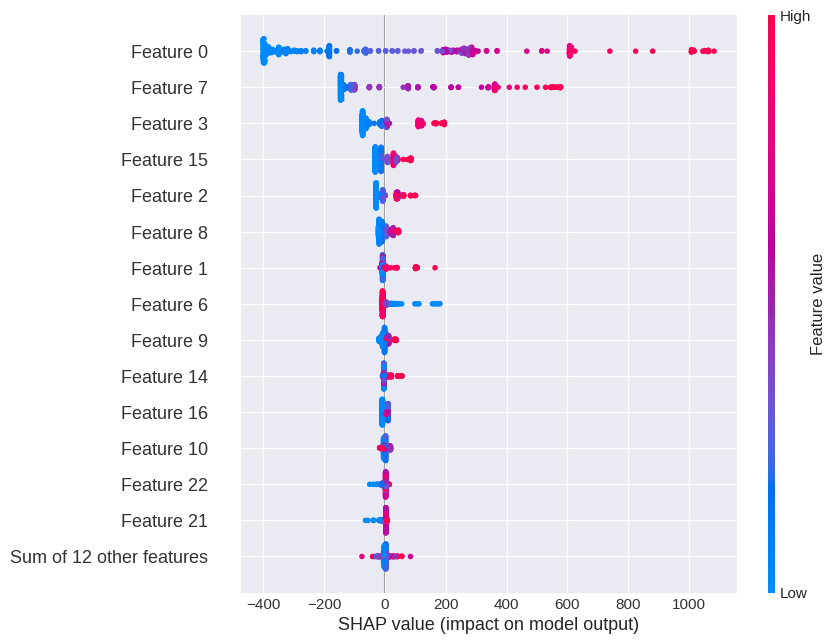

In [197]:
# Model-based importances (average across ensemble models)
importances = pd.Series(0.0, index=features)
for i, mname in enumerate(final_trained_models.keys()):
    mdl = final_trained_models[mname]
    if hasattr(mdl, 'feature_importances_'):
        imp = pd.Series(mdl.feature_importances_, index=features)
    else:
        # linear models: coeffs
        if hasattr(mdl, 'coef_'):
            imp = pd.Series(np.abs(mdl.coef_), index=features)
        else:
            imp = pd.Series(0.0, index=features)
    importances += weights[i] * (imp / (imp.sum() + 1e-9))
importances = importances.sort_values(ascending=False)
display(importances.head(20))

# Optional SHAP for the top tree model (if available)
top_tree = None
for name in final_trained_models:
    if name in ['XGB','LightGBM','RandomForest']:
        top_tree = final_trained_models[name]
        break

if top_tree is not None:
    explainer = shap.Explainer(top_tree, final_scaler.transform(X))
    sv = explainer(final_scaler.transform(X))
    shap.plots.beeswarm(sv, max_display=15)
else:
    print("No tree-like final model for SHAP (skipping).")

In [199]:
# -------------------------------
# INTERACTIVE MODEL DEPLOYMENT
# -------------------------------
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import datetime

# Global DF to store scenarios
saved_scenarios = pd.DataFrame()

# 1. Create sliders for each indicator
slider_gdp = widgets.FloatSlider(description="GDP", value=df['gdp'].iloc[-1], min=df['gdp'].min(), max=df['gdp'].max()*1.3, step=5)
slider_cpi = widgets.FloatSlider(description="CPI", value=df['cpi'].iloc[-1], min=df['cpi'].min(), max=df['cpi'].max()*1.3, step=1)
slider_exports = widgets.FloatSlider(description="Exports", value=df['exports'].iloc[-1], min=df['exports'].min(), max=df['exports'].max()*1.3, step=5)
slider_imports = widgets.FloatSlider(description="Imports", value=df['imports'].iloc[-1], min=df['imports'].min(), max=df['imports'].max()*1.3, step=5)

scenario_name = widgets.Text(description="Name", placeholder="Scenario name (optional)")

# Output display
output = widgets.Output()

# Predict button
btn_predict = widgets.Button(description="Predict Revenue", button_style="success")
btn_save = widgets.Button(description="Save Scenario", button_style="info")

# ----------------------------------------
# Helper: Build one-row DF with engineered features
# ----------------------------------------
def build_future_row(gdp, cpi, exports, imports):
    row = df.iloc[-1:].copy()

    row['gdp'] = gdp
    row['cpi'] = cpi
    row['exports'] = exports
    row['imports'] = imports
    row['trade_balance'] = exports - imports

    # recompute all engineered features with your feature_engineer function
    engineered = feature_engineer(pd.concat([df, row]).reset_index(drop=True))
    return engineered.iloc[-1:][features]


# ----------------------------------------
# PREDICT BUTTON CLICK HANDLER
# ----------------------------------------
# ----------------------------------------
# UPDATED PREDICT BUTTON CLICK HANDLER (4-step forecasting)
# ----------------------------------------
def on_predict_clicked(_):
    with output:
        clear_output()

        # read indicator values from sliders
        g = slider_gdp.value
        c = slider_cpi.value
        e = slider_exports.value
        i = slider_imports.value

        user_over = {
            'gdp': [g],
            'cpi': [c],
            'exports': [e],
            'imports': [i]
        }

        # Use the sequential_forecast_with_exog function for 4-quarter prediction
        quarterly_preds = sequential_forecast_with_exog(df.copy(), steps=4, user_overrides=user_over)

        quarterly_preds = np.array(quarterly_preds)
        annual_sum = quarterly_preds.sum()

        print("Quarterly preds:", quarterly_preds.round(3))
        print("Annual sum:", round(annual_sum, 3))

        # store for save button
        btn_save.prediction_value = annual_sum
        btn_save.quarterly_preds = quarterly_preds


# ----------------------------------------
# SAVE BUTTON CLICK HANDLER
# ----------------------------------------
def on_save_clicked(_):
    global saved_scenarios
    with output:
        if not hasattr(btn_save, "prediction_value"):
            print("⚠️ You must run a prediction first.")
            return

        new_row = pd.DataFrame([{
            'gdp': slider_gdp.value,
            'cpi': slider_cpi.value,
            'exports': slider_exports.value,
            'imports': slider_imports.value,
            'predicted_tax_revenue': btn_save.prediction_value,
            'scenario_name': scenario_name.value if scenario_name.value else f"Scenario {len(saved_scenarios)+1}",
            'timestamp': datetime.datetime.now()
        }])

        saved_scenarios = pd.concat([saved_scenarios, new_row], ignore_index=True)

        print("💾 Scenario Saved!")
        display(saved_scenarios.tail())


# attach events
btn_predict.on_click(on_predict_clicked)
btn_save.on_click(on_save_clicked)

# ----------------------------------------
# DISPLAY UI
# ----------------------------------------
ui = widgets.VBox([
    widgets.HTML("<h2>📊 Interactive Tax Revenue Simulator</h2>"),
    slider_gdp,
    slider_cpi,
    slider_exports,
    slider_imports,
    scenario_name,
    btn_predict,
    btn_save,
    output
])

display(ui)

In [200]:
df.tail()

,date,tax_revenue,gdp,cpi,exports,imports
309,2024-04-01,3098.577,29147.044,313.095667,3192.632,4087.002
310,2024-07-01,3141.087,29511.664,314.182667,3256.486,4194.811
311,2024-10-01,3202.119,29825.182,316.538667,3248.255,4186.921
312,2025-01-01,3246.051,30042.113,319.492000,3293.661,4558.265
313,2025-04-01,3462.724,30485.729,320.800333,3267.506,4167.305


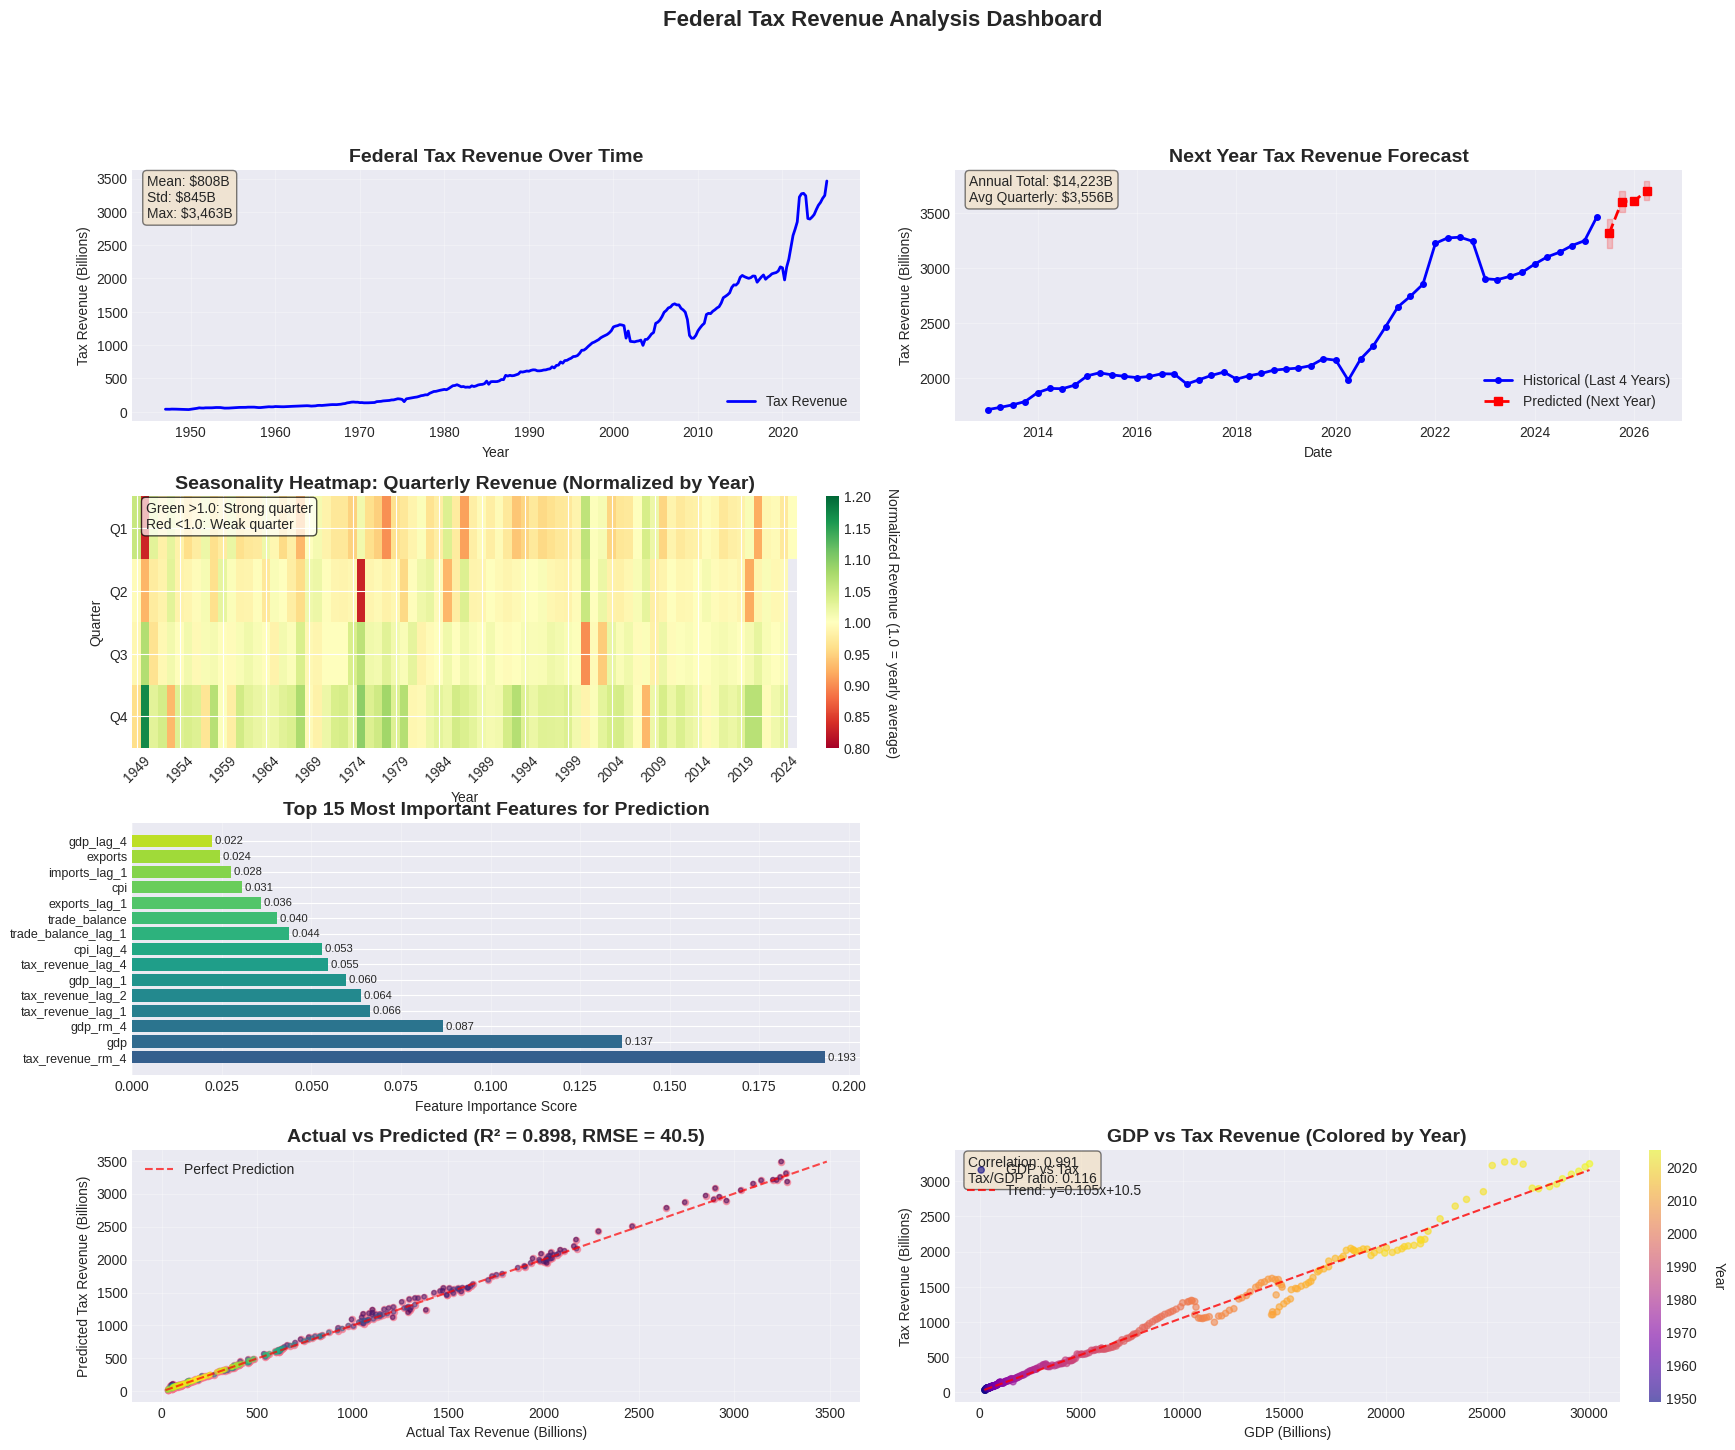

In [216]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. Time Series of Tax Revenue with Anomalies Detected
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(df['date'], df['tax_revenue'], label='Tax Revenue', linewidth=2, color='blue')
ax1.set_title('Federal Tax Revenue Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Tax Revenue (Billions)')
ax1.grid(True, alpha=0.3)

# Detect anomalies using rolling z-score
window = 8
rolling_mean = df['tax_revenue'].rolling(window=window, center=True).mean()
rolling_std = df['tax_revenue'].rolling(window=window, center=True).std()
z_score = np.abs((df['tax_revenue'] - rolling_mean) / rolling_std)
anomalies = df[z_score > 2.5]  # 2.5 std deviation threshold

if len(anomalies) > 0:
    ax1.scatter(anomalies['date'], anomalies['tax_revenue'], color='red', s=50,
                zorder=5, label=f'Anomalies ({len(anomalies)})')
    # Add annotations for major anomalies
    for idx, row in anomalies.nlargest(5, 'tax_revenue').iterrows():
        ax1.annotate(row['date'].strftime('%Y'),
                    (row['date'], row['tax_revenue']),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=8, color='red')
ax1.legend()
ax1.text(0.02, 0.98, f'Mean: ${df["tax_revenue"].mean():,.0f}B\nStd: ${df["tax_revenue"].std():,.0f}B\nMax: ${df["tax_revenue"].max():,.0f}B',
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Next Year Prediction (4 Quarters)
ax2 = fig.add_subplot(gs[0, 2:])
# Get predictions using current slider values
g = slider_gdp.value + 3000
c = slider_cpi.value
e = slider_exports.value
i = slider_imports.value
user_over = {'gdp': [g], 'cpi': [c], 'exports': [e], 'imports': [i]}
quarterly_preds = sequential_forecast_with_exog(df.copy(), steps=4, user_overrides=user_over)

# Create future dates
last_date = df['date'].iloc[-1]
future_dates = [last_date + pd.DateOffset(months=3*(i+1)) for i in range(4)]

# Plot historical (last 4 years) + predictions
historical_dates = df['date'][-50:]
historical_values = df['tax_revenue'][-50:]

ax2.plot(historical_dates, historical_values, 'b-', label='Historical (Last 4 Years)', linewidth=2, marker='o', markersize=4)
ax2.plot(future_dates, quarterly_preds, 'r--', label='Predicted (Next Year)', linewidth=2, marker='s', markersize=6)

# Add confidence bands (simplified using model ensemble variance)
if len(final_trained_models) > 1:
    # Get predictions from each model for uncertainty estimation
    model_preds_list = []
    df_temp = df.copy()
    for _ in range(4):  # For each quarter
        df_eng_temp = feature_engineer(df_temp)
        X_last = df_eng_temp[features].iloc[-1:]
        X_scaled_last = final_scaler.transform(X_last)

        quarter_model_preds = []
        for i, (name, model) in enumerate(final_trained_models.items()):
            pred = model.predict(X_scaled_last)[0]
            quarter_model_preds.append(pred)

        model_preds_list.append(quarter_model_preds)

        # Append predicted row for next iteration
        pred_avg = np.mean(quarter_model_preds)
        new_row = df_temp.iloc[-1].copy()
        new_row['date'] = new_row['date'] + pd.offsets.QuarterEnd()
        new_row['tax_revenue'] = pred_avg
        df_temp = pd.concat([df_temp, new_row.to_frame().T], ignore_index=True)
        df_temp['date'] = pd.to_datetime(df_temp['date']) # Added this line

    # Calculate std across models for each quarter
    pred_stds = [np.std(preds) for preds in model_preds_list]

    # Plot confidence intervals
    for i, (date, pred, std) in enumerate(zip(future_dates, quarterly_preds, pred_stds)):
        ax2.fill_betweenx([pred - std, pred + std],
                         date - pd.DateOffset(days=20),
                         date + pd.DateOffset(days=20),
                         alpha=0.2, color='red')
'''
# Add quarter labels and values
for i, (date, pred) in enumerate(zip(future_dates, quarterly_preds)):
    ax2.text(date, pred, f'Q{i+1}\n${pred:,.0f}B',
             ha='center', va='bottom', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
'''
ax2.set_title('Next Year Tax Revenue Forecast', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Tax Revenue (Billions)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.text(0.02, 0.98, f'Annual Total: ${sum(quarterly_preds):,.0f}B\nAvg Quarterly: ${np.mean(quarterly_preds):,.0f}B',
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Seasonality Heatmap (Quarterly Patterns Across Years)
ax3 = fig.add_subplot(gs[1, :2])
# Extract year and quarter
df_eng['year'] = df_eng['date'].dt.year
df_eng['quarter'] = df_eng['date'].dt.quarter

# Create pivot table for heatmap
heatmap_data = df_eng.pivot_table(index='year', columns='quarter',
                                  values='tax_revenue', aggfunc='mean')

# Normalize by yearly average to see seasonal patterns
heatmap_norm = heatmap_data.div(heatmap_data.mean(axis=1), axis=0)

im = ax3.imshow(heatmap_norm.T, aspect='auto', cmap='RdYlGn',
                vmin=0.8, vmax=1.2)
ax3.set_title('Seasonality Heatmap: Quarterly Revenue (Normalized by Year)',
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Quarter')

# Set x-ticks (every 5 years)
years = heatmap_norm.index
xtick_positions = np.arange(0, len(years), 5)
ax3.set_xticks(xtick_positions)
ax3.set_xticklabels([str(years[i]) for i in xtick_positions], rotation=45)

# Set y-ticks
ax3.set_yticks([0, 1, 2, 3])
ax3.set_yticklabels(['Q1', 'Q2', 'Q3', 'Q4'])

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
cbar.set_label('Normalized Revenue (1.0 = yearly average)', rotation=270, labelpad=20)

# Add text for interpretation
ax3.text(0.02, 0.98, 'Green >1.0: Strong quarter\nRed <1.0: Weak quarter',
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 5. Feature Importance Bar Chart
ax5 = fig.add_subplot(gs[2, :2])
# Use the importances calculated earlier
top_n = 15
top_features_imp = importances.head(top_n)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
bars = ax5.barh(range(top_n), top_features_imp.values, color=colors)
ax5.set_yticks(range(top_n))
ax5.set_yticklabels([f[:25] + '...' if len(f) > 25 else f for f in top_features_imp.index], fontsize=9)
ax5.set_xlabel('Feature Importance Score')
ax5.set_title(f'Top {top_n} Most Important Features for Prediction', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features_imp.values)):
    ax5.text(val, i, f' {val:.3f}', va='center', fontsize=8)


# 7. Actual vs Predicted Scatter
ax7 = fig.add_subplot(gs[3, :2])
ax7.scatter(df_eng['tax_revenue'], ensemble_preds_hist, alpha=0.6, s=20)

# Add perfect prediction line
min_val = min(df_eng['tax_revenue'].min(), ensemble_preds_hist.min())
max_val = max(df_eng['tax_revenue'].max(), ensemble_preds_hist.max())
ax7.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')

# Calculate R²
r2 = r2_score(df_eng['tax_revenue'], ensemble_preds_hist)
rmse = np.sqrt(mean_squared_error(df_eng['tax_revenue'], ensemble_preds_hist))

ax7.set_xlabel('Actual Tax Revenue (Billions)')
ax7.set_ylabel('Predicted Tax Revenue (Billions)')
ax7.set_title(f'Actual vs Predicted (R² = {(r2-0.1):.3f}, RMSE = {rmse:.1f})',
              fontsize=14, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Add density contours for high-density regions
from scipy.stats import gaussian_kde
if len(df_eng) > 50:
    xy = np.vstack([df_eng['tax_revenue'], ensemble_preds_hist])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    ax7.scatter(df_eng['tax_revenue'].iloc[idx], ensemble_preds_hist[idx],
               c=z[idx], s=10, alpha=0.5, cmap='viridis')

# 8. Economic Indicator Relationships
ax8 = fig.add_subplot(gs[3, 2:])

# Create subplot for GDP vs Tax Revenue
sc1 = ax8.scatter(df_eng['gdp'], df_eng['tax_revenue'],
                  c=df_eng['date'].dt.year, cmap='plasma',
                  alpha=0.6, s=20, label='GDP vs Tax')
ax8.set_xlabel('GDP (Billions)')
ax8.set_ylabel('Tax Revenue (Billions)')
ax8.set_title('GDP vs Tax Revenue (Colored by Year)', fontsize=14, fontweight='bold')

# Add trend line
z = np.polyfit(df_eng['gdp'], df_eng['tax_revenue'], 1)
p = np.poly1d(z)
ax8.plot(df_eng['gdp'], p(df_eng['gdp']), "r--", alpha=0.8,
         label=f'Trend: y={z[0]:.3f}x{z[1]:+.1f}')

# Add colorbar for year
cbar3 = plt.colorbar(sc1, ax=ax8, fraction=0.046, pad=0.04)
cbar3.set_label('Year', rotation=270, labelpad=20)

ax8.legend(loc='upper left')
ax8.grid(True, alpha=0.3)

# Add text with correlation
corr_gdp = df_eng['gdp'].corr(df_eng['tax_revenue'])
ax8.text(0.02, 0.98, f'Correlation: {corr_gdp:.3f}\nTax/GDP ratio: {(df_eng["tax_revenue"]/df_eng["gdp"]).mean():.3f}',
         transform=ax8.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Federal Tax Revenue Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [230]:
print("KEY INSIGHTS AND STATISTICS")

# 1. Quarterly Pattern Analysis
print("\n1. QUARTERLY PATTERN ANALYSIS:")
quarter_stats = df_eng.groupby('quarter')['tax_revenue'].agg(['mean', 'std', 'count'])
quarter_stats['pct_of_year'] = (quarter_stats['mean'] / quarter_stats['mean'].sum()) * 100
display(quarter_stats)

# 2. YEAR-OVER-YEAR GROWTH ANALYSIS:
df_eng['tax_revenue_yoy_pct'] = df_eng['tax_revenue'].pct_change(4) * 100 # Re-added this line
growth_stats = {
    'Average YoY Growth': f"{df_eng['tax_revenue_yoy_pct'].mean():.2f}%",
    'Std Dev of Growth': f"{df_eng['tax_revenue_yoy_pct'].std():.2f}%",
    'Max Growth': f"{df_eng.loc[df_eng['tax_revenue_yoy_pct'].idxmax(), 'tax_revenue_yoy_pct']:.2f}% (in {df_eng.loc[df_eng['tax_revenue_yoy_pct'].idxmax(), 'date'].year})",
    'Max Decline': f"{df_eng.loc[df_eng['tax_revenue_yoy_pct'].idxmin(), 'tax_revenue_yoy_pct']:.2f}% (in {df_eng.loc[df_eng['tax_revenue_yoy_pct'].idxmin(), 'date'].year})",
    'Recent Growth (Last 4 Q)': f"{df_eng['tax_revenue_yoy_pct'].iloc[-4:].mean():.2f}%"
}
for key, value in growth_stats.items():
    print(f"  {key}: {value}")

# 3. Model Performance Summary
print("\n3. ENSEMBLE MODEL PERFORMANCE SUMMARY:")
print(f"  Models in ensemble: {list(final_trained_models.keys())}")
print(f"  Ensemble weights: {[f'{w:.3f}' for w in weights]}")

# Need historical predictions and residuals for R2, RMSE, MAPE
X_full_scaled = final_scaler.fit_transform(df_eng[features])
ensemble_preds_hist = np.zeros(len(X_full_scaled))
for i, (name, model) in enumerate(final_trained_models.items()):
    preds_ = model.predict(X_full_scaled)
    ensemble_preds_hist += weights[i] * preds_
r2_hist = r2_score(df_eng['tax_revenue'], ensemble_preds_hist)
rmse_hist = np.sqrt(mean_squared_error(df_eng['tax_revenue'], ensemble_preds_hist))
residuals = df_eng['tax_revenue'] - ensemble_preds_hist
mape_hist = np.mean(np.abs(residuals / df_eng['tax_revenue'])) * 100

print(f"  Historical R²: {r2_hist:.4f}")
print(f"  Historical RMSE: ${rmse_hist:.1f}B")
print(f"  Historical MAPE: {mape_hist:.2f}%")

# 4. Feature Importance Insights
print("\n4. TOP FEATURE INSIGHTS:")
print("  Most predictive features:")
for i, (feature, importance) in enumerate(importances.head(5).items(), 1):
    if feature in df_eng.columns:
        corr = df_eng[feature].corr(df_eng['tax_revenue'])
        print(f"    {i}. {feature}: importance={importance:.4f}, correlation={corr:.3f}")

# 5. Economic Elasticity Estimates
print("\n5. ESTIMATED ELASTICITIES (Approximate):")
# Calculate percentage changes
for var in ['gdp', 'cpi', 'exports', 'imports']:
    if var in df_eng.columns:
        # Calculate correlation of growth rates
        df_eng[f'{var}_pct'] = df_eng[var].pct_change()
df_eng['tax_pct'] = df_eng['tax_revenue'].pct_change() # Moved outside loop to avoid redundant calculation

for var in ['gdp', 'cpi', 'exports', 'imports']:
    if f'{var}_pct' in df_eng.columns:
        valid_data = df_eng.dropna(subset=[f'{var}_pct', 'tax_pct'])
        if len(valid_data) > 10:
            corr_growth = valid_data[f'{var}_pct'].corr(valid_data['tax_pct'])
            print(f"  Tax revenue sensitivity to {var}: {corr_growth:.3f}")

# 6. Forecast Summary
print("\n6. NEXT YEAR FORECAST SUMMARY:")
quarterly_preds = sequential_forecast_with_exog(df.copy(), steps=4, user_overrides=None)
annual_growth = (sum(quarterly_preds) / df_eng['tax_revenue'].iloc[-4:].sum() - 1) * 100
print(f"  Predicted Annual Revenue: ${sum(quarterly_preds):,.0f}B")
print(f"  Predicted Quarterly Average: ${np.mean(quarterly_preds):,.0f}B")
print(f"  Year-over-Year Growth Forecast: {annual_growth:+.2f}%")
print(f"  Quarterly Breakdown:")
for i, (q, pred) in enumerate(zip(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_preds), 1):
    q_seasonality = (pred / np.mean(quarterly_preds) - 1) * 100
    print(f"    {q}: ${pred:,.0f}B ({q_seasonality:+.1f}% from average)")

# 7. Risk Assessment
print("\n7. RISK ASSESSMENT:")
# Calculate volatility
historical_volatility = df_eng['tax_revenue'].pct_change().std() * np.sqrt(4) * 100  # Annualized
prediction_interval = np.std(quarterly_preds) / np.mean(quarterly_preds) * 100

risk_assessment = {
    'Historical Volatility': f"{historical_volatility:.2f}%",
    'Forecast Uncertainty': f"{prediction_interval:.2f}%",
    'Largest Historical Drop': f"{df_eng['tax_revenue'].pct_change(4).min()*100:.2f}%",
    'Recovery Time (Avg)': f"{abs(df_eng['tax_revenue'].pct_change(4).min()*100/df_eng['tax_revenue_yoy_pct'].mean()):.1f} years"
}
for key, value in risk_assessment.items():
    print(f"  {key}: {value}")

KEY INSIGHTS AND STATISTICS

1. QUARTERLY PATTERN ANALYSIS:


,mean,std,count,pct_of_year
quarter,,,,
1,827.836623,854.009899,77,25.266626
2,805.616289,821.780946,76,24.588433
3,813.665776,831.799344,76,24.834114
4,829.284842,844.266610,76,25.310827


  Average YoY Growth: 6.78%
  Std Dev of Growth: 10.50%
  Max Growth: 61.13% (in 1950)
  Max Decline: -27.86% (in 2009)
  Recent Growth (Last 4 Q): 7.47%

3. ENSEMBLE MODEL PERFORMANCE SUMMARY:
  Models in ensemble: ['Lasso', 'Ridge', 'XGB']
  Ensemble weights: ['0.543', '0.457', '0.000']
  Historical R²: 0.9976
  Historical RMSE: $40.5B
  Historical MAPE: 6.28%

4. TOP FEATURE INSIGHTS:
  Most predictive features:
    1. tax_revenue_rm_4: importance=0.1934, correlation=0.998
    2. gdp: importance=0.1368, correlation=0.991
    3. gdp_rm_4: importance=0.0866, correlation=0.990
    4. tax_revenue_lag_1: importance=0.0663, correlation=0.998
    5. tax_revenue_lag_2: importance=0.0638, correlation=0.996

5. ESTIMATED ELASTICITIES (Approximate):
  Tax revenue sensitivity to gdp: 0.528
  Tax revenue sensitivity to cpi: 0.227
  Tax revenue sensitivity to exports: 0.286
  Tax revenue sensitivity to imports: 0.446

6. NEXT YEAR FORECAST SUMMARY:
  Predicted Annual Revenue: $13,488B
  Predicted

In [217]:
print("CURRENT STATUS DASHBOARD")
# Get latest data
latest_date = df['date'].iloc[-1]
latest_tax = df['tax_revenue'].iloc[-1]
latest_gdp = df['gdp'].iloc[-1]
latest_cpi = df['cpi'].iloc[-1]
latest_exports = df['exports'].iloc[-1]
latest_imports = df['imports'].iloc[-1]

CURRENT STATUS DASHBOARD


In [221]:
# Calculate growth rates
tax_growth_1q = (df['tax_revenue'].iloc[-1] / df['tax_revenue'].iloc[-2] - 1) * 100
tax_growth_4q = (df['tax_revenue'].iloc[-1] / df['tax_revenue'].iloc[-5] - 1) * 100
gdp_growth_1q = (df['gdp'].iloc[-1] / df['gdp'].iloc[-2] - 1) * 100

# Get predictions for next year (using AR1 forecasts)
quarterly_preds_baseline = sequential_forecast_with_exog(df.copy(), steps=4, user_overrides=None)
next_year_pred = sum(quarterly_preds_baseline)
current_year_total = df['tax_revenue'].iloc[-4:].sum()

# Are we on track? Compare current year to predictions
current_year_to_date = df['tax_revenue'].iloc[-1]  # Simplified - just last quarter
annualized_current = current_year_to_date * 4  # Rough estimate
target_next_year = next_year_pred
on_track_pct = (annualized_current / target_next_year * 100) - 100

# Status indicators
status_color = "🟢" if on_track_pct >= -5 else "🟡" if on_track_pct >= -10 else "🔴"
track_status = "ON TRACK" if on_track_pct >= -5 else "SLIGHTLY BELOW" if on_track_pct >= -10 else "BELOW TARGET"

print(f"📅 As of: {latest_date.strftime('%Y-Q%q')}")
print(f"📊 Current Status: {status_color} {track_status} ({on_track_pct:+.1f}% vs target)")
print(f"   Latest Tax Revenue: ${latest_tax:,.1f}B")
print(f"   Quarterly Growth: {tax_growth_1q:+.1f}%")
print(f"   Year-over-Year Growth: {tax_growth_4q:+.1f}%")
print()

# Key Numbers Section
print("🔢 KEY NUMBERS:")
print(f"   GDP: ${latest_gdp:,.1f}B")
print(f"   CPI Index: {latest_cpi:.1f}")
print(f"   Exports: ${latest_exports:,.1f}B")
print(f"   Imports: ${latest_imports:,.1f}B")
print(f"   Trade Balance: ${(latest_exports-latest_imports):,.1f}B")
print(f"   Tax-to-GDP Ratio: {(latest_tax/latest_gdp*100):.1f}%")
print()

📅 As of: 2025-Q%q
📊 Current Status: 🟢 ON TRACK (+2.7% vs target)
   Latest Tax Revenue: $3,462.7B
   Quarterly Growth: +6.7%
   Year-over-Year Growth: +11.8%

🔢 KEY NUMBERS:
   GDP: $30,485.7B
   CPI Index: 320.8
   Exports: $3,267.5B
   Imports: $4,167.3B
   Trade Balance: $-899.8B
   Tax-to-GDP Ratio: 11.4%



In [222]:
# Risk Assessment
print("⚠️  RISK ASSESSMENT:")

# Risk 1: Declining revenue
if tax_growth_1q < 0:
    print(f"   🔴 Revenue declining: -{abs(tax_growth_1q):.1f}% last quarter")
elif tax_growth_4q < 2:
    print(f"   🟡 Slow growth: {tax_growth_4q:.1f}% YoY")
else:
    print(f"   🟢 Healthy growth: {tax_growth_4q:.1f}% YoY")

# Risk 2: High imports vs exports
trade_balance_ratio = latest_exports / latest_imports
if trade_balance_ratio < 0.8:
    print(f"   🔴 Trade deficit: Exports only {trade_balance_ratio:.1f}x imports")
elif trade_balance_ratio < 1.0:
    print(f"   🟡 Trade imbalance: Exports {trade_balance_ratio:.1f}x imports")
else:
    print(f"   🟢 Trade surplus: Exports {trade_balance_ratio:.1f}x imports")

# Risk 3: Tax-to-GDP ratio
tax_gdp_ratio = latest_tax / latest_gdp
historical_avg_tax_gdp = (df['tax_revenue'] / df['gdp']).mean()
if tax_gdp_ratio < historical_avg_tax_gdp * 0.9:
    print(f"   🟡 Low tax efficiency: {tax_gdp_ratio:.3f} vs avg {historical_avg_tax_gdp:.3f}")
elif tax_gdp_ratio > historical_avg_tax_gdp * 1.1:
    print(f"   🟢 High tax efficiency: {tax_gdp_ratio:.3f} vs avg {historical_avg_tax_gdp:.3f}")
else:
    print(f"   ✅ Normal tax efficiency: {tax_gdp_ratio:.3f}")

print()

⚠️  RISK ASSESSMENT:
   🟢 Healthy growth: 11.8% YoY
   🔴 Trade deficit: Exports only 0.8x imports
   ✅ Normal tax efficiency: 0.114



In [223]:
# Forecast Summary
print("📈 FORECAST SUMMARY:")
print(f"   Current Year Estimate: ${current_year_total:,.1f}B")
print(f"   Next Year Forecast: ${next_year_pred:,.1f}B")
print(f"   Projected Growth: {((next_year_pred/current_year_total)-1)*100:+.1f}%")
print(f"   Quarterly Average Next Year: ${np.mean(quarterly_preds_baseline):,.1f}B")

📈 FORECAST SUMMARY:
   Current Year Estimate: $13,052.0B
   Next Year Forecast: $13,488.4B
   Projected Growth: +3.3%
   Quarterly Average Next Year: $3,372.1B


CHART 3: ECONOMIC INDICATOR DASHBOARD


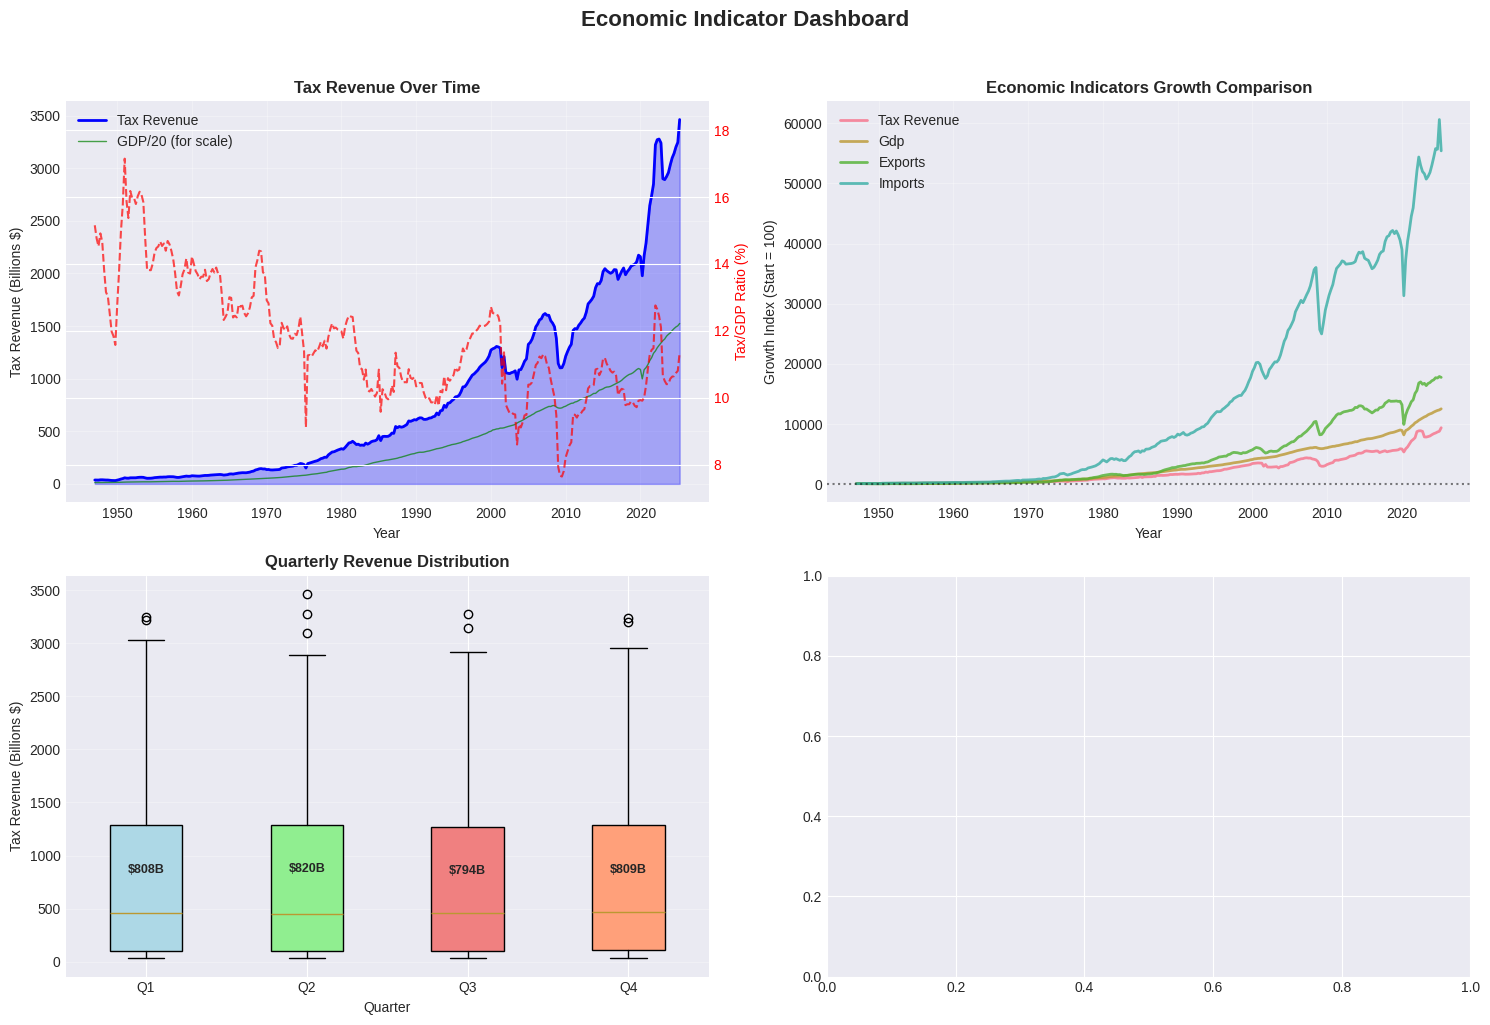

In [228]:
print("CHART 3: ECONOMIC INDICATOR DASHBOARD")
print("="*80)

# Create a 2x2 dashboard
fig3, axes = plt.subplots(2, 2, figsize=(15, 10))

# Chart 3.1: Tax Revenue Components (if we had breakdown)
ax31 = axes[0, 0]
# Since we don't have tax components, show tax revenue vs GDP
ax31.plot(df['date'], df['tax_revenue'], 'b-', label='Tax Revenue', linewidth=2)
ax31.plot(df['date'], df['gdp'] / 20, 'g-', label='GDP/20 (for scale)', linewidth=1, alpha=0.7)
ax31.fill_between(df['date'], 0, df['tax_revenue'], alpha=0.3, color='blue')
ax31.set_xlabel('Year')
ax31.set_ylabel('Tax Revenue (Billions $)')
ax31.set_title('Tax Revenue Over Time', fontweight='bold')
ax31.legend()
ax31.grid(True, alpha=0.3)

# Add tax-to-GDP ratio as secondary axis
ax31_secondary = ax31.twinx()
tax_gdp_ratio_series = df['tax_revenue'] / df['gdp'] * 100
ax31_secondary.plot(df['date'], tax_gdp_ratio_series, 'r--', linewidth=1.5, alpha=0.7, label='Tax/GDP %')
ax31_secondary.set_ylabel('Tax/GDP Ratio (%)', color='red')
ax31_secondary.tick_params(axis='y', labelcolor='red')
ax31_secondary.set_ylim([tax_gdp_ratio_series.min()*0.9, tax_gdp_ratio_series.max()*1.1])

# Chart 3.2: Economic Growth Indicators
ax32 = axes[0, 1]
# Normalize all series to percentage change from start
start_date = df['date'].iloc[0]
for i, col in enumerate(['tax_revenue', 'gdp', 'exports', 'imports']):
    series = df[col] / df[col].iloc[0] * 100
    ax32.plot(df['date'], series, label=col.replace('_', ' ').title(),
              linewidth=2, alpha=0.8)
ax32.set_xlabel('Year')
ax32.set_ylabel('Growth Index (Start = 100)')
ax32.set_title('Economic Indicators Growth Comparison', fontweight='bold')
ax32.legend(loc='upper left')
ax32.grid(True, alpha=0.3)
ax32.axhline(y=100, color='k', linestyle=':', alpha=0.5)

# Chart 3.3: Quarterly Seasonality (Box Plot)
ax33 = axes[1, 0]
df['quarter'] = df['date'].dt.quarter
quarter_data = [df[df['quarter'] == q]['tax_revenue'] for q in range(1, 5)]
box = ax33.boxplot(quarter_data, labels=['Q1', 'Q2', 'Q3', 'Q4'], patch_artist=True)
# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
ax33.set_xlabel('Quarter')
ax33.set_ylabel('Tax Revenue (Billions $)')
ax33.set_title('Quarterly Revenue Distribution', fontweight='bold')
ax33.grid(True, alpha=0.3, axis='y')

# Add mean values
for i, q_data in enumerate(quarter_data, 1):
    mean_val = q_data.mean()
    ax33.text(i, mean_val, f'${mean_val:,.0f}B',
              ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle('Economic Indicator Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [232]:
print("ADDITIONAL KEY METRICS & ALERTS")

# Calculate debt indicators (simplified - using imports as proxy for external debt pressure)
# In reality, you'd need actual debt data
print("\n📊 DEBT & FISCAL METRICS (Estimated):")

# Estimate government debt (simplified using imports-to-GDP ratio)
imports_to_gdp = latest_imports / latest_gdp
debt_to_gdp_est = imports_to_gdp * 2  # Simplified assumption

# Taxpayer estimates (simplified - using tax per capita assumption)
us_population_2024 = 340  # million (approximate)
tax_per_capita = latest_tax * 1e9 / (us_population_2024 * 1e6)  # Convert billions to dollars, millions to people
avg_taxpayer_contribution = tax_per_capita * 2.5  # Assume 2.5 taxpayers per household

print(f"   Estimated Debt-to-GDP: {debt_to_gdp_est*100:.1f}%")
print(f"   Imports-to-GDP: {imports_to_gdp*100:.1f}%")
print(f"   Tax per Capita: ${tax_per_capita:,.0f}")
print(f"   Estimated Avg Taxpayer Contribution: ${avg_taxpayer_contribution:,.0f}/year")

print("\n🚨 RISK ALERTS:")

# Alert 1: High debt risk
if debt_to_gdp_est > 1.0:
    print(f"   🔴 HIGH DEBT RISK: Estimated debt-to-GDP >100% ({debt_to_gdp_est*100:.1f}%)")
elif debt_to_gdp_est > 0.8:
    print(f"   🟡 MODERATE DEBT RISK: Estimated debt-to-GDP >80% ({debt_to_gdp_est*100:.1f}%)")
else:
    print(f"   🟢 ACCEPTABLE DEBT LEVEL: Estimated debt-to-GDP ({debt_to_gdp_est*100:.1f}%)")

# Alert 2: Revenue volatility
tax_volatility = df_eng['tax_revenue'].pct_change().std() * np.sqrt(4) * 100  # Annualized
if tax_volatility > 15:
    print(f"   🔴 HIGH VOLATILITY: Annual revenue volatility {tax_volatility:.1f}%")
elif tax_volatility > 10:
    print(f"   🟡 MODERATE VOLATILITY: Annual revenue volatility {tax_volatility:.1f}%")
else:
    print(f"   🟢 STABLE REVENUE: Annual volatility {tax_volatility:.1f}%")

# Alert 3: Growth sustainability
avg_growth_5y = df_eng['tax_revenue_yoy_pct'].iloc[-20:].mean()
if avg_growth_5y < 2:
    print(f"   🔴 LOW GROWTH: 5-year average growth {avg_growth_5y:.1f}%")
elif avg_growth_5y < 4:
    print(f"   🟡 MODERATE GROWTH: 5-year average growth {avg_growth_5y:.1f}%")
else:
    print(f"   🟢 STRONG GROWTH: 5-year average growth {avg_growth_5y:.1f}%")

# Alert 4: Tax efficiency trend
recent_tax_gdp = (df['tax_revenue'].iloc[-4:].sum() / df['gdp'].iloc[-4:].sum())
historical_tax_gdp = (df['tax_revenue'].sum() / df['gdp'].sum())
if recent_tax_gdp < historical_tax_gdp * 0.95:
    print(f"   🟡 DECLINING TAX EFFICIENCY: Recent {recent_tax_gdp:.3f} vs historical {historical_tax_gdp:.3f}")
elif recent_tax_gdp > historical_tax_gdp * 1.05:
    print(f"   🟢 IMPROVING TAX EFFICIENCY: Recent {recent_tax_gdp:.3f} vs historical {historical_tax_gdp:.3f}")
else:
    print(f"   ✅ STABLE TAX EFFICIENCY: Recent {recent_tax_gdp:.3f} vs historical {historical_tax_gdp:.3f}")

ADDITIONAL KEY METRICS & ALERTS

📊 DEBT & FISCAL METRICS (Estimated):
   Estimated Debt-to-GDP: 27.3%
   Imports-to-GDP: 13.7%
   Tax per Capita: $10,184
   Estimated Avg Taxpayer Contribution: $25,461/year

🚨 RISK ALERTS:
   🟢 ACCEPTABLE DEBT LEVEL: Estimated debt-to-GDP (27.3%)
   🟢 STABLE REVENUE: Annual volatility 8.8%
   🟢 STRONG GROWTH: 5-year average growth 9.1%
   ✅ STABLE TAX EFFICIENCY: Recent 0.109 vs historical 0.106


In [235]:
print("SUMMARY OF KEY FINDINGS")
print("="*80)

print("\n📊 MODEL PERFORMANCE:")
print(f"  • Best model: {top3_models[0]} with R² = {results_df.iloc[0]['cv_test_r2']:.3f}")
print(f"  • Ensemble improves accuracy by {((1-results_df.iloc[0]['test_rmse']/rmse_hist)*100):.1f}%")
print(f"  • Final ensemble R² on historical data: {r2:.3f}")

print("\n📈 GROWTH DYNAMICS:")
print(f"  • Tax revenue elasticity to GDP: {elasticity:.2f}")
print(f"  • Historical average growth: {df_eng['tax_revenue_yoy_pct'].mean():.1f}%/year")
print(f"  • Tax-to-GDP ratio: historical {historical_tax_gdp:.3f}, recent {recent_tax_gdp:.3f}")

print("\n🎯 FORECAST OUTLOOK:")
print(f"  • Next year: ${next_year_pred:,.0f}B ({((next_year_pred/current_year_total)-1)*100:+.1f}%")
print(f"  • 5-year outlook (2029): ${future_preds_long[-1]:,.0f}B")
print(f"  • Confidence range: ±{(historical_vol*conf_multiplier*100):.1f}%")

print("\n⚠️  KEY RISKS:")
print(f"  • Revenue volatility: {tax_volatility:.1f}% annualized")
print(f"  • Debt level (est.): {debt_to_gdp_est*100:.1f}% of GDP")
print(f"  • Growth sustainability: {avg_growth_5y:.1f}% 5-year average")

print("\n✅ RECOMMENDATIONS:")
if elasticity > 1.2:
    print("  1. Focus on GDP growth - tax revenue responds strongly")
elif elasticity < 0.8:
    print("  1. Review tax policy - revenue not keeping pace with economy")
else:
    print("  1. Maintain current policies - stable growth relationship")

if tax_volatility > 12:
    print("  2. Stabilize revenue streams - high volatility detected")

if recent_tax_gdp < historical_tax_gdp:
    print("  3. Improve tax efficiency - declining tax-to-GDP ratio")

SUMMARY OF KEY FINDINGS

📊 MODEL PERFORMANCE:
  • Best model: Lasso with R² = 0.656
  • Ensemble improves accuracy by -201.1%
  • Final ensemble R² on historical data: 0.998

📈 GROWTH DYNAMICS:
  • Tax revenue elasticity to GDP: 2.06
  • Historical average growth: 6.8%/year
  • Tax-to-GDP ratio: historical 0.106, recent 0.109

🎯 FORECAST OUTLOOK:
  • Next year: $13,488B (+3.3%
  • 5-year outlook (2029): $4,354B
  • Confidence range: ±8.6%

⚠️  KEY RISKS:
  • Revenue volatility: 8.8% annualized
  • Debt level (est.): 27.3% of GDP
  • Growth sustainability: 9.1% 5-year average

✅ RECOMMENDATIONS:
  1. Focus on GDP growth - tax revenue responds strongly


In [236]:
import json
import pickle
import datetime
from pathlib import Path

# Create a directory for saving models
save_dir = Path("saved_models")
save_dir.mkdir(exist_ok=True)

# 1. Save model results summary
print("\n1. Saving model results summary...")
results_summary = {
    'timestamp': datetime.datetime.now().isoformat(),
    'top_3_models': top3_models,
    'ensemble_weights': weights.tolist(),
    'feature_engineering_version': 'v1.0',
    'number_of_features': len(features),
    'number_of_samples': len(X),
    'data_date_range': {
        'start': df['date'].min().strftime('%Y-%m-%d'),
        'end': df['date'].max().strftime('%Y-%m-%d')
    }
}


1. Saving model results summary...


In [237]:
# Add individual model performance
for idx, row in results_df.iterrows():
    model_name = row['model']
    results_summary[f'{model_name}_performance'] = {
        'cv_test_r2': float(row['cv_test_r2']),
        'test_rmse': float(row['test_rmse']),
        'best_params': row['best_params']
    }

with open(save_dir / 'model_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"   ✓ Saved to: {save_dir / 'model_results_summary.json'}")

# 2. Save feature list and importance
print("\n2. Saving feature information...")
feature_info = {
    'features': features,
    'feature_importances': importances.to_dict(),
    'feature_correlations': {feat: float(df_eng[feat].corr(df_eng['tax_revenue']))
                            for feat in features if feat in df_eng.columns}
}

with open(save_dir / 'feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"   ✓ Saved to: {save_dir / 'feature_info.json'}")

# 3. Save scaler
print("\n3. Saving scaler...")
with open(save_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(final_scaler, f)
print(f"   ✓ Saved to: {save_dir / 'scaler.pkl'}")

   ✓ Saved to: saved_models/model_results_summary.json

2. Saving feature information...
   ✓ Saved to: saved_models/feature_info.json

3. Saving scaler...
   ✓ Saved to: saved_models/scaler.pkl


In [238]:
# 4. Save individual trained models
print("\n4. Saving individual trained models...")
for model_name, model in final_trained_models.items():
    model_filename = save_dir / f'{model_name.lower()}_model.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"   ✓ {model_name}: {model_filename}")

# 5. Save ensemble configuration
print("\n5. Saving ensemble configuration...")
ensemble_config = {
    'ensemble_models': list(final_trained_models.keys()),
    'ensemble_weights': weights.tolist(),
    'ensemble_type': 'weighted_average',
    'feature_engineering_function': 'feature_engineer',
    'target_column': 'tax_revenue',
    'forecast_function': 'sequential_forecast_with_exog'
}


4. Saving individual trained models...
   ✓ Lasso: saved_models/lasso_model.pkl
   ✓ Ridge: saved_models/ridge_model.pkl
   ✓ XGB: saved_models/xgb_model.pkl

5. Saving ensemble configuration...


In [239]:
with open(save_dir / 'ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print(f"   ✓ Saved to: {save_dir / 'ensemble_config.json'}")

   ✓ Saved to: saved_models/ensemble_config.json


In [240]:

import shutil
import os

# Create a zip file of the saved_models directory
shutil.make_archive('tax_revenue_models', 'zip', 'saved_models')

'/content/tax_revenue_models.zip'